# #11 Mean-Variance Portfolio

여기서 최적화는 하지않고, 대신 
1. `from pandas.plotting import scatter_matrix` 로 각 자산간 주가의 Corr 분석,
2. `from scipy.spatial import ConvexHull` 로 randomly weighted portfolios들의 Cvx Hull을 plot,
3. `from sklearn.neighbors import KDTree` 로 current portfolio에 가장 가까운 5개의 최근접 포트폴리오 추론<br>
을 수행한다.

[ref](https://mkjjo.github.io/finance/2019/01/27/mean-variance-portfolio.html)<br>
[ref 2](https://github.com/vsmolyakov/fin/blob/master/portfolio_opt.py):

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from pandas.plotting import scatter_matrix
from scipy.spatial import ConvexHull
from sklearn.neighbors import KDTree

from datetime import datetime

np.random.seed(0)

In [2]:
tickers = ['MSFT', 'TLT', 'SPY', 'VTIP', 'VCLT', 'IAU', 'BCI']
df = yf.download(tickers, start='2017-06-01', end='2023-04-01')['Adj Close']
df.head()

[*********************100%***********************]  7 of 7 completed


,BCI,IAU,MSFT,SPY,TLT,VCLT,VTIP
Date,,,,,,,
2017-06-01,15.392170,24.420000,65.030823,218.480835,108.937927,73.038727,41.170403
2017-06-02,15.392170,24.580000,66.570778,219.208038,110.227791,73.720482,41.187050
2017-06-05,15.290111,24.620001,67.053192,219.046432,109.543373,73.363739,41.153759
2017-06-06,15.290111,24.900000,67.275826,218.346146,110.140045,73.736359,41.220341
2017-06-07,15.290111,24.780001,67.155243,218.750168,109.613556,73.585716,41.137119


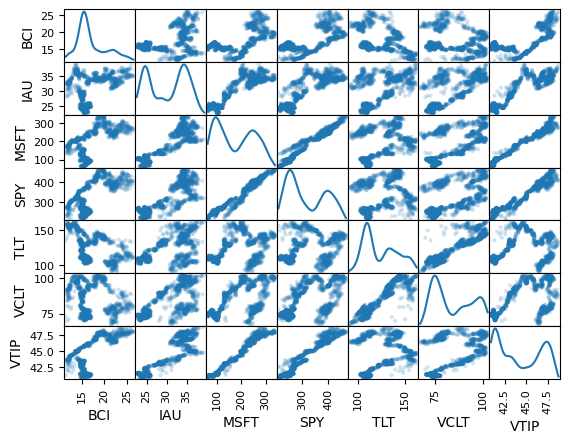

In [3]:
# correlations between (the price of) assets
scatter_matrix(df, alpha=0.2, diagonal='kde')
plt.show()

In [4]:
ret = df.pct_change().dropna() * 100
ret.head()

,BCI,IAU,MSFT,SPY,TLT,VCLT,VTIP
Date,,,,,,,
2017-06-02,0.000000,0.655200,2.368039,0.332845,1.184035,0.933416,0.040435
2017-06-05,-0.663060,0.162738,0.724664,-0.073723,-0.620912,-0.483913,-0.080828
2017-06-06,0.000000,1.137282,0.332025,-0.319698,0.544690,0.507907,0.161788
2017-06-07,0.000000,-0.481923,-0.179236,0.185037,-0.478018,-0.204299,-0.201894
2017-06-08,0.041714,-0.726393,-0.607850,0.049247,-0.264163,-0.172358,-0.060683


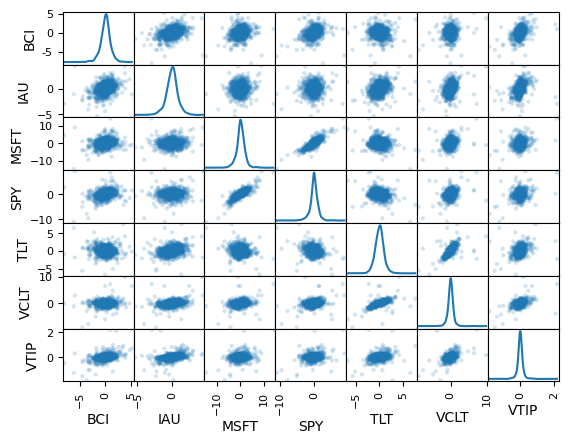

In [5]:
# this might be useless
scatter_matrix(ret, alpha=0.2, diagonal='kde')
plt.show()

In [6]:
# generate random weights
num_assets = len(tickers)
# wgt = (1e4-5e3) * np.random.rand(num_assets, 1) + 5e3  # 굳이 이렇게 할 이유는 없음
wgt = np.random.rand(num_assets)
wgt /= np.sum(wgt)

In [7]:
Sigma = df.cov().values
Corr = df.corr().values
volatility = np.sqrt(wgt.T @ Sigma @ wgt)

print('Cov:', Sigma)
print('Corr:', Corr)
print('Std. Dev.:', volatility)

Cov: [[ 1.07496856e+01  6.50521300e+00  1.61215303e+02  1.65315245e+02
  -2.35200887e+01 -4.96205083e+00  5.74951432e+00]
 [ 6.50521300e+00  2.31867276e+01  3.41220230e+02  2.96775983e+02
   4.86362843e+01  3.47229144e+01  1.10675669e+01]
 [ 1.61215303e+02  3.41220230e+02  6.35480158e+03  5.76897320e+03
   5.57264700e+02  5.03773403e+02  2.01301253e+02]
 [ 1.65315245e+02  2.96775983e+02  5.76897320e+03  5.45941348e+03
   3.74998579e+02  4.30534605e+02  1.84230409e+02]
 [-2.35200887e+01  4.86362843e+01  5.57264700e+02  3.74998579e+02
   3.19920528e+02  1.68482329e+02  1.47259206e+01]
 [-4.96205083e+00  3.47229144e+01  5.03773403e+02  4.30534605e+02
   1.68482329e+02  1.06872829e+02  1.46027694e+01]
 [ 5.74951432e+00  1.10675669e+01  2.01301253e+02  1.84230409e+02
   1.47259206e+01  1.46027694e+01  6.57255794e+00]]
Corr: [[ 1.          0.4120443   0.61681849  0.68240473 -0.40106985 -0.14639616
   0.68401569]
 [ 0.4120443   1.          0.8889228   0.83413439  0.56470236  0.69752983
   0.8

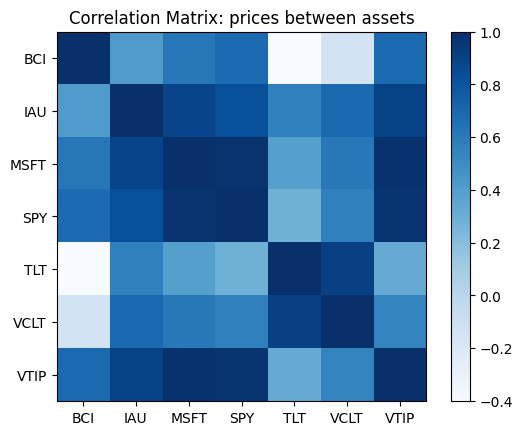

In [8]:
# Corr. visualization
plt.figure()
plt.title('Correlation Matrix: prices between assets')
plt.imshow(Corr, cmap=plt.cm.Blues)
plt.xticks(range(num_assets), df.columns)
plt.yticks(range(num_assets), df.columns)
plt.colorbar()
plt.show()

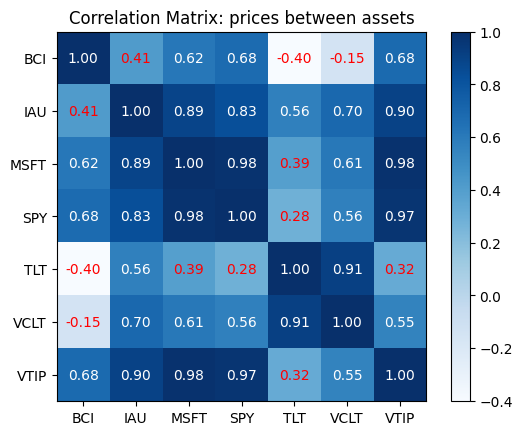

In [9]:
# Correlation Matrix: prices between assets
plt.figure()
plt.title('Correlation Matrix: prices between assets')
im = plt.imshow(Corr, cmap=plt.cm.Blues)
plt.xticks(range(num_assets), df.columns)
plt.yticks(range(num_assets), df.columns)
plt.colorbar(im)

# Corr 값을 텍스트로 표기
for i in range(num_assets):
    for j in range(num_assets):
        plt.text(j, i, f"{Corr[i,j]:.2f}", ha='center', va='center', color='white' if Corr[i,j] > 0.5 else 'red')  # 원 코드는 'red' 대신 'black'

plt.show()

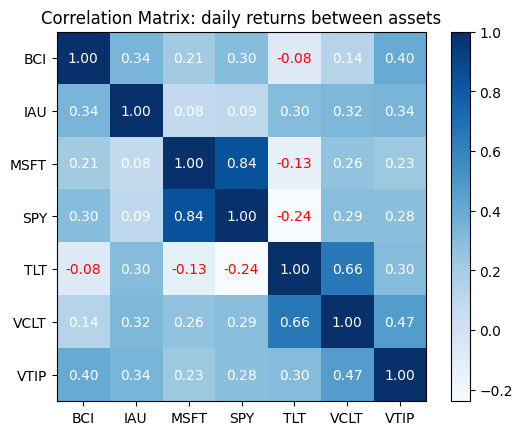

In [10]:
# Correlation Matrix: daily returns between assets
Corr_ret = ret.corr().values

plt.figure()
plt.title('Correlation Matrix: daily returns between assets')
im = plt.imshow(Corr_ret, cmap=plt.cm.Blues)
plt.xticks(range(num_assets), ret.columns)
plt.yticks(range(num_assets), ret.columns)
plt.colorbar(im)

# Corr_ret 값을 텍스트로 표기
for i in range(num_assets):
    for j in range(num_assets):
        plt.text(j, i, f"{Corr_ret[i,j]:.2f}", ha='center', va='center', color='white' if Corr_ret[i,j] > 0.0 else 'red')  # 원 코드는 'red' 대신 'black'

plt.show()

In [11]:
ret.mean() * 100

BCI      2.582011
IAU      3.289484
MSFT    11.903495
SPY      5.078738
TLT      0.276747
VCLT     0.920378
VTIP     1.035833
dtype: float64

In [12]:
# ret 대신 avg_price를 기준으로 num_sum (1000) 번 simulation
num_sim = 1000
W = np.random.rand(num_sim, num_assets)  # 즉, 7 x 1000 행렬: 이렇게 복잡하게 할 필요는 없음
W /= np.sum(W, axis=1).reshape(num_sim, 1)

ret_sim = np.zeros(num_sim)
Sig_sim = np.zeros(num_sim)
avg_price = df.mean().values

# num_sim 번의 시뮬레이션 수행
for i in range(num_sim):
    ret_sim[i] = np.sum(avg_price * W[i,:])
    Sig_sim[i] = np.sqrt(W[i,:].T @ Sigma @ W[i,:])    

points = np.vstack((Sig_sim, ret_sim)).T  # 변동성(Sig_sim)과 예상 수익률(ret_sim)을 열로 가지는 2차원 배열 points를 생성: 2 x 1000
hull = ConvexHull(points)

In [13]:
avg_price * wgt

array([ 2.40441677,  5.5246917 , 27.70264301, 44.73422376, 13.41033332,
       13.91900827,  4.94677105])

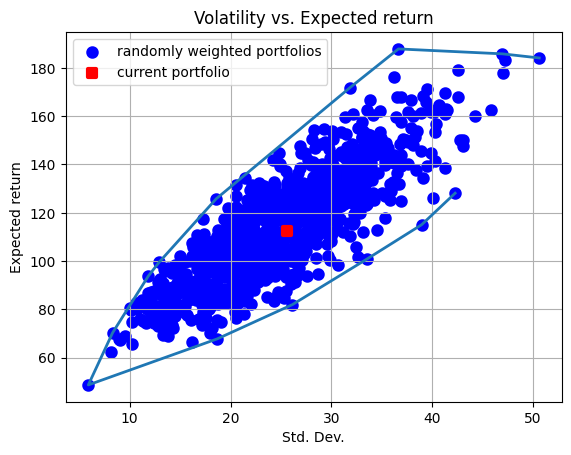

In [14]:
plt.figure()
# 무작위로 생성된 포트폴리오를 산점도로 표시
plt.scatter(Sig_sim, ret_sim, marker='o', color='b', linewidth=3.0, label='randomly weighted portfolios')

# current 포트폴리오
plt.scatter(volatility, np.sum(avg_price * wgt), marker='s', color='r', linewidth=3.0, label='current portfolio')
plt.plot(points[hull.vertices, 0], points[hull.vertices, 1], linewidth=2.0)  # cvx hull
plt.title('Volatility vs. Expected return')
plt.xlabel('Std. Dev.')
plt.ylabel('Expected return')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
knn = 5  #  최근접 이웃의 개수
kdt = KDTree(points)
query_point = np.array([80000, 60000]).reshape(1, -1)
kdt_dist, kdt_idx = kdt.query(query_point, k=knn)  # KD트리로 쿼리 포인트의 최근접 이웃 포트폴리오 검색/knn개의 최근접 이웃 반환

print('top-%d closest to query portfolios: ' %knn)
print('returns: ', ret_sim[kdt_idx.ravel()])  # ravel() 함수는 다차원 배열을 1차원으로 평탄화하는 역할
print('Sigmas(Covariances): ', Sig_sim[kdt_idx.ravel()])

top-5 closest to query portfolios: 
returns:  [184.08073746 185.78757092 183.18100322 177.72139717 187.82444876]
Sigmas(Covariances):  [50.61771204 46.96371326 47.20146006 47.01911213 36.65280626]


`query point`란 데이터셋에서 원하는 정보를 검색하기 위해 사용되는 점(데이터)을 의미하며, 일반적으로 데이터셋에서 특정 조건이나 요구사항을 만족하는 데이터를 찾을 때 쿼리 포인트를 사용한다.

`KD 트리`에서의 쿼리 포인트는 주어진 데이터셋에 대해 어떤 조건을 만족하는 데이터를 찾기 위한 검색 점이다. 이 때, KD 트리는 공간을 분할하여 데이터를 효율적으로 탐색하기 위한 자료구조다. 쿼리 포인트를 KD 트리에 적용하면, 해당 점과 가장 가까운 이웃 데이터를 검색하거나 특정 조건을 만족하는 데이터를 찾을 수 있다.

위 코드에서 `kdt_idx.ravel()`은 `kdt_idx` 배열을 1차원으로 변환하여 해당 이웃 포트폴리오들의 인덱스를 일렬로 나열한다.